In [367]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import pairwise_distances, DistanceMetric, ndcg_score
from tqdm import tqdm
from sklearn.neighbors import KDTree
import ast
import math
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
plt.rcParams["figure.figsize"] = (5, 4)

In [16]:
data_folder_path = "data_task2"

# Load data
def data_loader(path, folder=data_folder_path):
    # Returns a tuple with all data needed: data in numpy, ids
    df = pd.read_csv(os.path.join(data_folder_path, path), delimiter='\t')

    numpy_array = df.loc[:, df.columns != 'id'].to_numpy(
        dtype=np.float32)  # we are taking float16 to reduce memory issues
    return df['id'].to_numpy(), numpy_array[:, 1:]

In [17]:
# Importing song metadata
info_df = pd.read_csv(os.path.join(data_folder_path, "id_information_mmsr.tsv"), delimiter='\t')
genres_df = pd.read_csv(os.path.join(data_folder_path, "id_genres_mmsr.tsv"), delimiter='\t')

# Introductory part on data anylsis
Displaying: Most frequent genres, average number of genres per track, average number of tracks that share one genre...

In [18]:
#display("Display singular genre songs and multiple genre songs")
#display(genres_df['genre'].apply(lambda x: ',' in x).value_counts())
display("61025 songs have multiple genres, 7616 songs have only one genre")


# Calculate average genre size per track
def average_genre_size(genres_df):
    # Returns a list with the average genre size per track
    genre_size = []
    for genres in genres_df['genre']:
        genre_size.append(len(genres.split(',')))
    return genre_size


display("Average number of genres per track")
np.mean(average_genre_size(genres_df))

'61025 songs have multiple genres, 7616 songs have only one genre'

'Average number of genres per track'

7.176279483107764

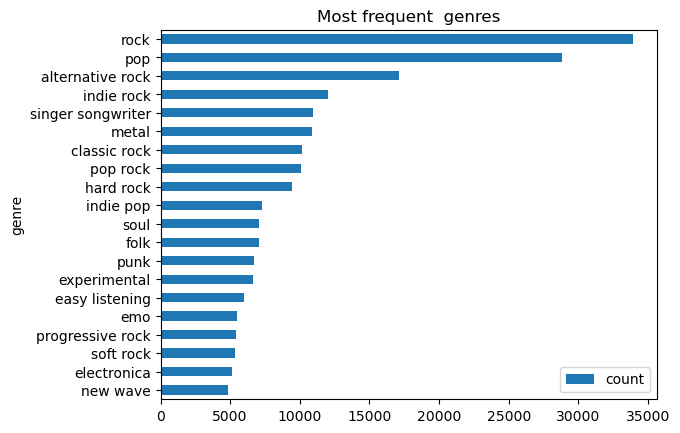

In [19]:
# Filter all genres which contain "pop"
def get_most_frequent_genres(genres_df):
    # Returns a dataframe with only pop genres
    all_genres_sum = []
    all_genres = []
    for genres in genres_df['genre']:
        for x in genres.split("'"):
            if (not ("[" in x or "]" in x or "," in x)):
                if x in all_genres:
                    all_genres_sum[all_genres.index(x)] += 1
                else:
                    all_genres.append(x)
                    all_genres_sum.append(1)
    return all_genres, all_genres_sum


dict_genres, dict_genres_sum = get_most_frequent_genres(genres_df)

pd.DataFrame({'genre': dict_genres, 'count': dict_genres_sum}).sort_values(by='count', ascending=False).head(20)[
::-1].plot.barh(x='genre', y='count', title="Most frequent  genres")
pass

<h2>Find out how many tracks approximately share one genre</h2>

In [20]:
def get_genres_matrix(genres_df):
    # Returns a dataframe with only pop genres
    all_genres = []
    for genres in genres_df['genre']:
        for x in genres.split("'"):
            if not ("[" in x or "]" in x or "," in x):
                if x not in all_genres:
                    all_genres.append(x)

    np_genres = np.zeros(shape=(len(genres_df), len(all_genres)))
    # fill the matrix
    for i, genres in enumerate(genres_df['genre']):
        for x in genres.split("'"):
            if (not ("[" in x or "]" in x or "," in x)):
                np_genres[i, all_genres.index(x)] = 1
    return np_genres, all_genres


genres_numbers, all_genres = get_genres_matrix(genres_df)
display("Number of genres: " + str(len(all_genres)))

'Number of genres: 1670'

In [21]:
def find_similar_genres(genres_numbers):
    # Find all columns which are 1 in the first row

    top_similar = []
    top_sums_values = []
    for column in range(0, genres_numbers.shape[1]):
        tmp_matrix = genres_numbers[genres_numbers[:, column] == 1]
        sum_matrix = np.sum(tmp_matrix, axis=0)
        # find biggest top_sum
        top_tmp = np.argpartition(sum_matrix, -10)[-10:]
        # We are sorting them and cutting the first value
        top_tmp = top_tmp[np.argsort(sum_matrix[top_tmp])][::-1][1:]
        top_sums_value = sum_matrix[top_tmp]
        top_similar.append((column, top_tmp))
        top_sums_values.append(top_sums_value)

    return top_sums_values, top_similar


# Display the top 3 genres which are most similar to the first genre
a, b = find_similar_genres(genres_numbers)

for i in range(0, genres_numbers.shape[1]):
    print("Genre: " + all_genres[i])
    for j in range(0, 3):
        print("Similar genre: " + all_genres[b[i][1][j]] + " with " + str(a[i][j]) + " tracks")
    print("")

Genre: pop
Similar genre: rock with 17048.0 tracks
Similar genre: pop rock with 8528.0 tracks
Similar genre: alternative rock with 8290.0 tracks

Genre: beats
Similar genre: pop with 274.0 tracks
Similar genre: electronica with 244.0 tracks
Similar genre: rock with 224.0 tracks

Genre: underground hip hop
Similar genre: hip hop with 287.0 tracks
Similar genre: rap with 260.0 tracks
Similar genre: alternative hip hop with 117.0 tracks

Genre: lo fi
Similar genre: rock with 1459.0 tracks
Similar genre: indie rock with 1391.0 tracks
Similar genre: indie pop with 980.0 tracks

Genre: hard rock
Similar genre: rock with 8919.0 tracks
Similar genre: alternative rock with 5220.0 tracks
Similar genre: metal with 4933.0 tracks

Genre: classic rock
Similar genre: rock with 9560.0 tracks
Similar genre: pop with 6121.0 tracks
Similar genre: hard rock with 4448.0 tracks

Genre: rock
Similar genre: pop with 17048.0 tracks
Similar genre: alternative rock with 15652.0 tracks
Similar genre: indie rock w

Similar genre: punk with 198.0 tracks
Similar genre: alternative rock with 172.0 tracks

Genre: french pop
Similar genre: pop with 207.0 tracks
Similar genre: chanson with 93.0 tracks
Similar genre: rock with 72.0 tracks

Genre: minimal synth
Similar genre: synthpop with 61.0 tracks
Similar genre: post punk with 41.0 tracks
Similar genre: new wave with 40.0 tracks

Genre: future garage
Similar genre: experimental with 29.0 tracks
Similar genre: dubstep with 27.0 tracks
Similar genre: ambient with 25.0 tracks

Genre: uk garage
Similar genre: house with 47.0 tracks
Similar genre: electronica with 46.0 tracks
Similar genre: pop with 42.0 tracks

Genre: wonky
Similar genre: experimental with 28.0 tracks
Similar genre: electronica with 19.0 tracks
Similar genre: downtempo with 18.0 tracks

Genre: spanish pop
Similar genre: pop with 197.0 tracks
Similar genre: latin with 155.0 tracks
Similar genre: latin pop with 125.0 tracks

Genre: nu disco
Similar genre: pop with 222.0 tracks
Similar genr

Similar genre: rock with 48.0 tracks
Similar genre: new wave with 39.0 tracks
Similar genre: punk with 36.0 tracks

Genre: swancore
Similar genre: swancore with 3.0 tracks
Similar genre: post hardcore with 3.0 tracks
Similar genre: metalcore with 2.0 tracks

Genre: funk melody
Similar genre: funk with 6.0 tracks
Similar genre: pop with 3.0 tracks
Similar genre: funk carioca with 3.0 tracks

Genre: funk carioca
Similar genre: pop with 18.0 tracks
Similar genre: funk with 18.0 tracks
Similar genre: jazz with 9.0 tracks

Genre: jazz piano
Similar genre: jazz with 90.0 tracks
Similar genre: blues with 60.0 tracks
Similar genre: pop with 58.0 tracks

Genre: rai
Similar genre: rai with 15.0 tracks
Similar genre: world with 13.0 tracks
Similar genre: classic rock with 13.0 tracks

Genre: black speed metal
Similar genre: speed metal with 5.0 tracks
Similar genre: black speed metal with 5.0 tracks
Similar genre: thrash metal with 4.0 tracks

Genre: sludgecore
Similar genre: sludge metal with 26

Similar genre: poetry with 6.0 tracks

Genre: swedish indie pop
Similar genre: indie pop with 9.0 tracks
Similar genre: swedish indie pop with 9.0 tracks
Similar genre: rock with 8.0 tracks

Genre: grebo
Similar genre: pop rock with 2.0 tracks
Similar genre: indie rock with 2.0 tracks
Similar genre: alternative rock with 2.0 tracks

Genre: demoscene
Similar genre: trip hop with 3.0 tracks
Similar genre: electronica with 3.0 tracks
Similar genre: ambient with 2.0 tracks

Genre: metallic hardcore
Similar genre: hardcore with 19.0 tracks
Similar genre: metalcore with 17.0 tracks
Similar genre: hardcore punk with 12.0 tracks

Genre: melodic deathcore
Similar genre: deathcore with 36.0 tracks
Similar genre: death metal with 34.0 tracks
Similar genre: metalcore with 33.0 tracks

Genre: filmi
Similar genre: filmi with 1.0 tracks
Similar genre: hip hop with 1.0 tracks
Similar genre: grime with 1.0 tracks

Genre: melodic doom
Similar genre: melodic doom with 6.0 tracks
Similar genre: metal with

Genre: sertanejo universitario
Similar genre: sertanejo with 3.0 tracks
Similar genre: pagode with 1.0 tracks
Similar genre: harp with 0.0 tracks

Genre: pop emo
Similar genre: punk with 4.0 tracks
Similar genre: emo with 4.0 tracks
Similar genre: rock with 4.0 tracks

Genre: scottish indie
Similar genre: indie rock with 14.0 tracks
Similar genre: rock with 11.0 tracks
Similar genre: alternative rock with 8.0 tracks

Genre: actors
Similar genre: actors with 3.0 tracks
Similar genre: ambient with 2.0 tracks
Similar genre: electronica with 2.0 tracks

Genre: brooklyn indie
Similar genre: brooklyn indie with 1.0 tracks
Similar genre: rock with 1.0 tracks
Similar genre: viral pop with 0.0 tracks

Genre: thrash groove metal
Similar genre: thrash groove metal with 12.0 tracks
Similar genre: metal with 12.0 tracks
Similar genre: thrash metal with 12.0 tracks

Genre: trash rock
Similar genre: rock with 5.0 tracks
Similar genre: alternative rock with 4.0 tracks
Similar genre: punk with 3.0 trac

Genre: shiver pop
Similar genre: indie rock with 2.0 tracks
Similar genre: pop with 1.0 tracks
Similar genre: chill out with 1.0 tracks

Genre: levenslied
Similar genre: levenslied with 1.0 tracks
Similar genre: easy listening with 1.0 tracks
Similar genre: schlager with 1.0 tracks

Genre: german punk
Similar genre: german punk with 1.0 tracks
Similar genre: punk with 1.0 tracks
Similar genre: ska with 1.0 tracks

Genre: horror synth
Similar genre: art rock with 1.0 tracks
Similar genre: electropop with 1.0 tracks
Similar genre: industrial rock with 1.0 tracks

Genre: australian indie
Similar genre: pop with 2.0 tracks
Similar genre: synthpop with 2.0 tracks
Similar genre: indie rock with 2.0 tracks

Genre: partyschlager
Similar genre: eurodance with 1.0 tracks
Similar genre: house with 1.0 tracks
Similar genre: trance with 1.0 tracks

Genre: bulgarian pop
Similar genre: bulgarian pop with 1.0 tracks
Similar genre: dark black metal with 0.0 tracks
Similar genre: southern metal with 0.0

<h2>Discussion</h2>
We can see, that most songs are dominated by the most popular genres. If you are in an "unlikely" genre, it is hard to recommend a similar songs, because there aren't that many similar.

# Evaluation Framework

<h2>Util functions</h2>

In [416]:
def filter_df(df, **args):
    if not args:
        raise AttributeError("**args required")
    query = ''
    for k, v in args.items():
        query += f"{k}=='{v}' and "
    query = query[:-5]  # Removing the last 'and' of our query
    return df.query(query)

from scipy import sparse

def LSA(matrix, k):
    u, s, vt = sparse.linalg.svds(matrix.astype(np.float32).T, k=k)
    embedding_small = vt.T
    return embedding_small.astype(np.float16)

def get_genres(query_id):
    return list(genres_df[genres_df["id"]==query_id]["genre"])

def flatten(l):
    return [item for sublist in l for item in sublist]

def calculate_relevance_confusion_matrix(ids):
    X = np.full((len(ids), len(ids)), True)
    for i, i_id in enumerate(tqdm(ids)):
        set_i = set(get_genres(i_id))
        for j, j_id in enumerate(ids):
            if i + j > len(ids):
                break
            set_j = set(get_genres(j_id))
            is_relevant = set_i & set_j
            X[i, j] = is_relevant
            X[j, i] = is_relevant
    return X

<h2> Performance metrics </h2>

In [396]:
def get_precision(nr_relevant_predicted_in_k, k):
    return nr_relevant_predicted_in_k/k

def get_recall(nr_relevant_predicted_in_k, nr_of_relevant_target_in_k):
    if nr_of_relevant_target_in_k == 0:
        return 1
    return nr_relevant_predicted_in_k/nr_of_relevant_target_in_k

def get_average_precision(first_k_predictions, nr_of_relevant_target_in_k):
    ap = 0
    for i in range(len(first_k_predictions)):
        this_first_k_predictions = first_k_predictions[:i+1] 
        this_nr_relevant_predicted_in_k = len(this_first_k_predictions[this_first_k_predictions==1])
        this_nr_of_relevant_target_in_k = max(i+1, nr_of_relevant_target_in_k)
        ap += ((1 if i+1 < nr_of_relevant_target_in_k else 0) * get_precision(this_nr_relevant_predicted_in_k, this_nr_of_relevant_target_in_k))
    return (ap/nr_of_relevant_target_in_k if nr_of_relevant_target_in_k > 0 else 1)
        
def get_ndcg(first_k_predictions, nr_of_relevant_target_in_k):
    dcg = 0
    idcg = 0
    for i, _ in enumerate(first_k_predictions):
        dcg += first_k_predictions[i] / np.log2(i + 2)
        idcg += (1 if i <= nr_of_relevant_target_in_k else 0) / np.log2(i + 2)
    return dcg/idcg

def get_mean_reciprocal_rank(first_k_predictions):
    for i, pred in enumerate(first_k_predictions):
        if pred == 1:
            return 1/(i+1)
    return 0

<h2>Evaluation Functions</h2>

In [442]:
def preprocess_predictions(query_index, retrived_indices, relevance_matrix):
    relevance_matrix_row = relevance_matrix[query_index]
    relevance_matrix_row_elements = relevance_matrix_row[retrived_indices]
    predictions = relevance_matrix_row_elements.astype(int)
    return predictions, relevance_matrix_row

def preprocess_k_predictions(predictions, relevance_matrix_row, k):
    nr_of_relevant_target_in_k = min(len(relevance_matrix_row[relevance_matrix_row]), k)
    first_k_predictions = predictions[:k]
    nr_relevant_predicted_in_k = len(first_k_predictions[first_k_predictions==1])
    return first_k_predictions, nr_relevant_predicted_in_k, nr_of_relevant_target_in_k
     
def evaluate_metrics(query_index, retrived_indices, relevance_matrix, k_values):
    predictions, relevance_matrix_row = preprocess_predictions(query_index, retrived_indices, relevance_matrix)
    result = [[], [], [], [], []] # avg prec, mmr, ndcg, prec, recall
    
    # for average prec, mmr, ndcg only compute metrics at k_values
    for k in k_values:
        first_k_predictions, nr_relevant_predicted_in_k, nr_of_relevant_target_in_k = preprocess_k_predictions(predictions, relevance_matrix_row, k)
        result[0].append(get_average_precision(first_k_predictions, nr_of_relevant_target_in_k))
        result[1].append(get_mean_reciprocal_rank(first_k_predictions))
        result[2].append(get_ndcg(first_k_predictions, nr_of_relevant_target_in_k))
    
    # for prec, recall compute at each k
    for k in range(1, max(k_values)+1):
        first_k_predictions, nr_relevant_predicted_in_k, nr_of_relevant_target_in_k = preprocess_k_predictions(predictions, relevance_matrix_row, k)
        result[3].append(get_precision(nr_relevant_predicted_in_k, k))
        result[4].append(get_recall(nr_relevant_predicted_in_k, nr_of_relevant_target_in_k))
    return flatten(result)
        
def format_evaluation(eval_mean, eval_std, recommender_name, embedding_name, metric, k_values):
    
    # 1. repartition flattened table eval metrics and merge mean/std as string for displaying
    table_result = []
    for i, k in enumerate(k_values):
        table_result.append([recommender_name, embedding_name, metric, k])
        for j in range(3):
            table_result[i].append(f"μ={round(eval_mean[j*len(k_values)+i], 3)}, σ={round(eval_std[j*len(k_values)+i], 3)}")
            
    # 2. reorder prec/recall for plot
    first_prec_index = 3*len(k_values)
    first_recall_index = first_prec_index+max(k_values)
    plot_result = [eval_mean[first_prec_index:first_recall_index], eval_mean[first_recall_index:]]

    return table_result, plot_result


def plot_precision_recall(recommender_name, embedding_name, metric, plot_result):
    plt.plot(plot_result[1], plot_result[0], label=f"{recommender_name}, {embedding_name}, {metric}")

In [435]:
class DummyBaselineRecommender:
    
    def evaluate(self, query_ids, relevance_matrix, k_values):
        stats = [] 
        query_indices = list(range(len(query_ids)))
        for query_index, query_id in enumerate(query_ids):
            this_query_indices = query_indices.copy()
            this_query_indices.remove(query_index)
            retrived_indices = np.random.choice(np.array(this_query_indices), size=max(k_values))
            stats.append(evaluate_metrics(
                query_index,
                retrived_indices,
                relevance_matrix,
                k_values
            ))
        return format_evaluation(
            np.mean(stats, axis=0),
            np.std(stats, axis=0),
            self.__class__.__name__,
            "-",
            "-",
            k_values
        )

class KnnRecommender:
    
    def __init__(self, embedding_name, embedding_array, embedding_ids, metric, k):
        self.embedding_name = embedding_name
        self.embedding_array = embedding_array
        self.metric = metric
        self.k = k
        # precompute nearest neighbors
        distance_metric_object = DistanceMetric.get_metric(self.metric)
        tree = KDTree(self.embedding_array, metric=distance_metric_object)
        self.top_k_similar_crosswise_indicies = tree.query(self.embedding_array, k=self.k, return_distance=False)       
        
    def evaluate(self, query_ids, relevance_matrix, k_values):
        if max(k_values) > self.k:
            raise AttributeError(f"Recommender is trained on k={self.k}, cant evaluate for higher k={max(k_values)}!")
        stats = [] 
        for query_index, (query_id, retrived_indices) in enumerate(zip(query_ids, self.top_k_similar_crosswise_indicies)):
            stats.append(evaluate_metrics(
                query_index,
                retrived_indices,
                relevance_matrix,
                k_values
            ))
        return format_evaluation(
            np.mean(stats, axis=0),
            np.std(stats, axis=0),
            self.__class__.__name__,
            self.embedding_name,
            self.metric,
            k_values
        )

In [371]:
def conf_evaluation(this_conf, sample_fraction):
    """
    Evaluates a embedding-metric combinations to compare
    :param this_conf: configurations of embeddings and metrics
    :param sample_fraction: random subset of embeddings to evaluate (for faster execution)
    """
    
    print("Number of evaluations:", (len(this_conf["embeddings"].keys()) * len(this_conf["metrics"])+1)*len(this_conf["k_values"]))
    
    table_result = []
    
    # DummyBaselineRecommender evaluation
    print(f'\nEvaluating dummy baseline')
    embedding_ids = list(this_conf["embeddings"].items())[0][1].ids
    sample_embedding_indices = np.random.randint(0, len(embedding_ids), int(len(embedding_ids)*sample_fraction))
    sample_embedding_ids = embedding_ids[sample_embedding_indices]
    relevance_matrix = calculate_relevance_confusion_matrix(sample_embedding_ids)
    dummy_baseline_recommmender = DummyBaselineRecommender()
    this_table_result, this_plot_result = dummy_baseline_recommmender.evaluate(sample_embedding_ids, relevance_matrix, this_conf["k_values"])
    table_result.extend(this_table_result)
    plot_precision_recall(dummy_baseline_recommmender.__class__.__name__, "-", "-", this_plot_result)
    
    # KnnRecommender evaluation
    for embedding_name, (embedding_ids, embedding_array) in this_conf["embeddings"].items():
        sample_embedding_indices = np.random.randint(0, len(embedding_ids), int(len(embedding_ids)*sample_fraction))
        sample_embedding_ids = embedding_ids[sample_embedding_indices]
        sample_embedding_array = embedding_array[sample_embedding_indices]
        print(f'\nEvaluating {embedding_name}')
        relevance_matrix = calculate_relevance_confusion_matrix(sample_embedding_ids)
        for metric in this_conf["metrics"]:
            knn_recommender = KnnRecommender(
                embedding_name,
                sample_embedding_array,
                sample_embedding_ids,
                metric,
                max(this_conf["k_values"])
            )
            this_table_result, this_plot_result = knn_recommender.evaluate(sample_embedding_ids, relevance_matrix, this_conf["k_values"])
            table_result.extend(this_table_result)
            plot_precision_recall(knn_recommender.__class__.__name__, embedding_name, metric, this_plot_result)

    table_df = pd.DataFrame(data=table_result, columns=["recommender", "embedding", "metric", "k", "avg. precision", "mmr", "ndcg"])
    display(table_df)
    plt.title('Precision-Recall Plot', size=10)
    plt.xlabel('recall', size=8)
    plt.ylabel('precision', size=8)
    plt.legend(title='Combination', prop={'size': 5})
    plt.show()

# Evaluation: Lyric, Audi and Visual Features

In [25]:
# Importing the lyrics data
tfidf_ids, tfidf_array = data_loader("id_lyrics_tf-idf_mmsr.tsv")
word2vec_ids, word2vec_array = data_loader("id_lyrics_word2vec_mmsr.tsv")
bert_ids, bert_array = data_loader("id_lyrics_bert_mmsr.tsv")

In [26]:
# Considering the fact that the id's might not always be in order, we extract them.
locfluc_ids, locfluc_array = data_loader("id_blf_logfluc_mmsr.tsv")
resnet_ids, resnet_array = data_loader("id_resnet_mmsr.tsv")
spectral_ids, spectral_array = data_loader("id_blf_spectral_mmsr.tsv")
mfcc_ids, mfcc_array = data_loader("id_mfcc_bow_mmsr.tsv")
# replace nAn values with 0
locfluc_array = np.nan_to_num(locfluc_array)
resnet_array = np.nan_to_num(resnet_array)
spectral_array = np.nan_to_num(spectral_array)
mfcc_array = np.nan_to_num(mfcc_array)

In [419]:
Embedding = namedtuple('Embedding', ['ids', 'array'])
conf = {
    "embeddings": {
        # lyric features
        "tf_idf_small": Embedding(tfidf_ids, LSA(tfidf_array, 10)), 
        #"word2vec_small":  Embedding(word2vec_ids, LSA(word2vec_array, 10)),
        #"bert_small":  Embedding(bert_ids, LSA(bert_array, 10)),
        #audio and visual features
        "locfluc_small": Embedding(locfluc_ids, LSA(locfluc_array, 10)),
        #"resnet_small": Embedding(resnet_ids, LSA(resnet_array, 10)),
        "spectral_small": Embedding(spectral_ids, LSA(spectral_array, 10)),
        #"mfcc_small": Embedding(mfcc_ids, LSA(mfcc_array, 10))
    },
    "metrics" : [
        'manhattan',
        'euclidean',
    ],
    "k_values": [
        10,
        20
    ]
}

Number of evaluations: 14

Evaluating dummy baseline


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.30it/s]



Evaluating tf_idf_small


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.03it/s]



Evaluating locfluc_small


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.40it/s]



Evaluating spectral_small


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 14.32it/s]


,recommender,embedding,metric,k,avg. precision,mmr,ndcg
0,DummyBaselineRecommender,-,-,10,"μ=0.189, σ=0.133","μ=0.549, σ=0.357","μ=0.434, σ=0.252"
1,DummyBaselineRecommender,-,-,20,"μ=0.201, σ=0.136","μ=0.551, σ=0.354","μ=0.531, σ=0.253"
2,KnnRecommender,tf_idf_small,manhattan,10,"μ=0.282, σ=0.11","μ=1.0, σ=0.0","μ=0.669, σ=0.154"
3,KnnRecommender,tf_idf_small,manhattan,20,"μ=0.284, σ=0.111","μ=1.0, σ=0.0","μ=0.743, σ=0.1"
4,KnnRecommender,tf_idf_small,euclidean,10,"μ=0.28, σ=0.117","μ=1.0, σ=0.0","μ=0.675, σ=0.176"
5,KnnRecommender,tf_idf_small,euclidean,20,"μ=0.282, σ=0.116","μ=1.0, σ=0.0","μ=0.744, σ=0.102"
6,KnnRecommender,locfluc_small,manhattan,10,"μ=0.257, σ=0.11","μ=1.0, σ=0.0","μ=0.62, σ=0.171"
7,KnnRecommender,locfluc_small,manhattan,20,"μ=0.254, σ=0.106","μ=1.0, σ=0.0","μ=0.671, σ=0.113"
8,KnnRecommender,locfluc_small,euclidean,10,"μ=0.251, σ=0.106","μ=1.0, σ=0.0","μ=0.615, σ=0.165"
9,KnnRecommender,locfluc_small,euclidean,20,"μ=0.251, σ=0.105","μ=1.0, σ=0.0","μ=0.682, σ=0.11"


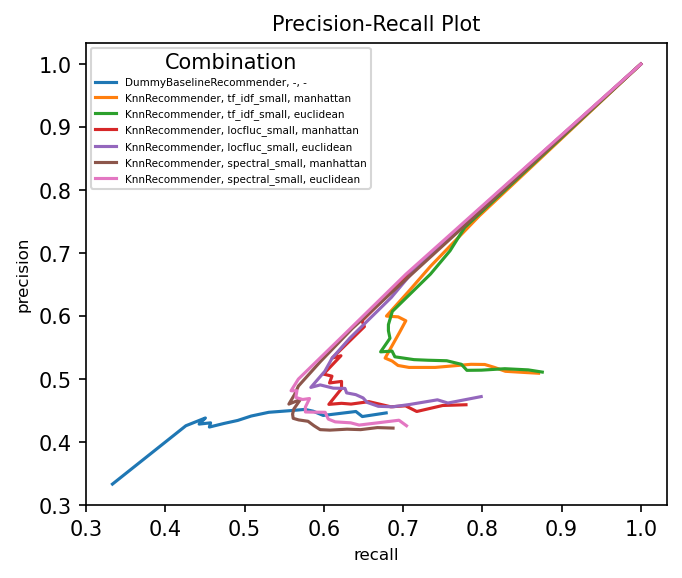

In [443]:
conf_evaluation(conf, sample_fraction=0.0004)